
# Comparing different clustering algorithms on toy datasets


This example aims at showing characteristics of different clustering algorithms discussing in class on 2D datasets. These examples give some intuition about the algorithms but note however that this intuition might not apply to very high dimensional data. We applied two versions of hierarchical clustering, one taken from the SciPy library that provides functions for drawing dendrograms and also has several linkage functions; the other one is taken from the Scikit-Learn library and only has average and ward linkage.

In [27]:
import time

import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn import mixture

# scipy implementation of hierarchical clustering
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

%matplotlib inline

## Generate Datasets
We generate the sample problems using the functions provided by the sklearn.datasets library

In [40]:
np.random.seed(1234)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
C = np.array([[2.0, -0.1], [1.7, .4]])

noisy_circles = sklearn.datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = sklearn.datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
diagonal = np.r_[
    np.dot(np.random.randn(n_samples, 2), np.array([[0.2, 0.2], [1, .4]])), 
#     .7 * np.random.randn(n_samples/3, 2) + np.array([-6, 3]),
    np.array([-1, -6])+np.dot(np.random.randn(n_samples, 2), np.array([[1.0, -0.5], [-1, .2]]))
]

diagonal = [diagonal, [0]*n_samples + [1]*n_samples]


colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [37]:
data = [noisy_circles, noisy_moons, blobs, diagonal, no_structure]

clustering_names = ['HC (Single)', 
                    'HC (Average)', 
                    'k-Means',
                    'DBSCAN', 
                    'EM']

We apply every algorithm to each dataset and compare the results produced

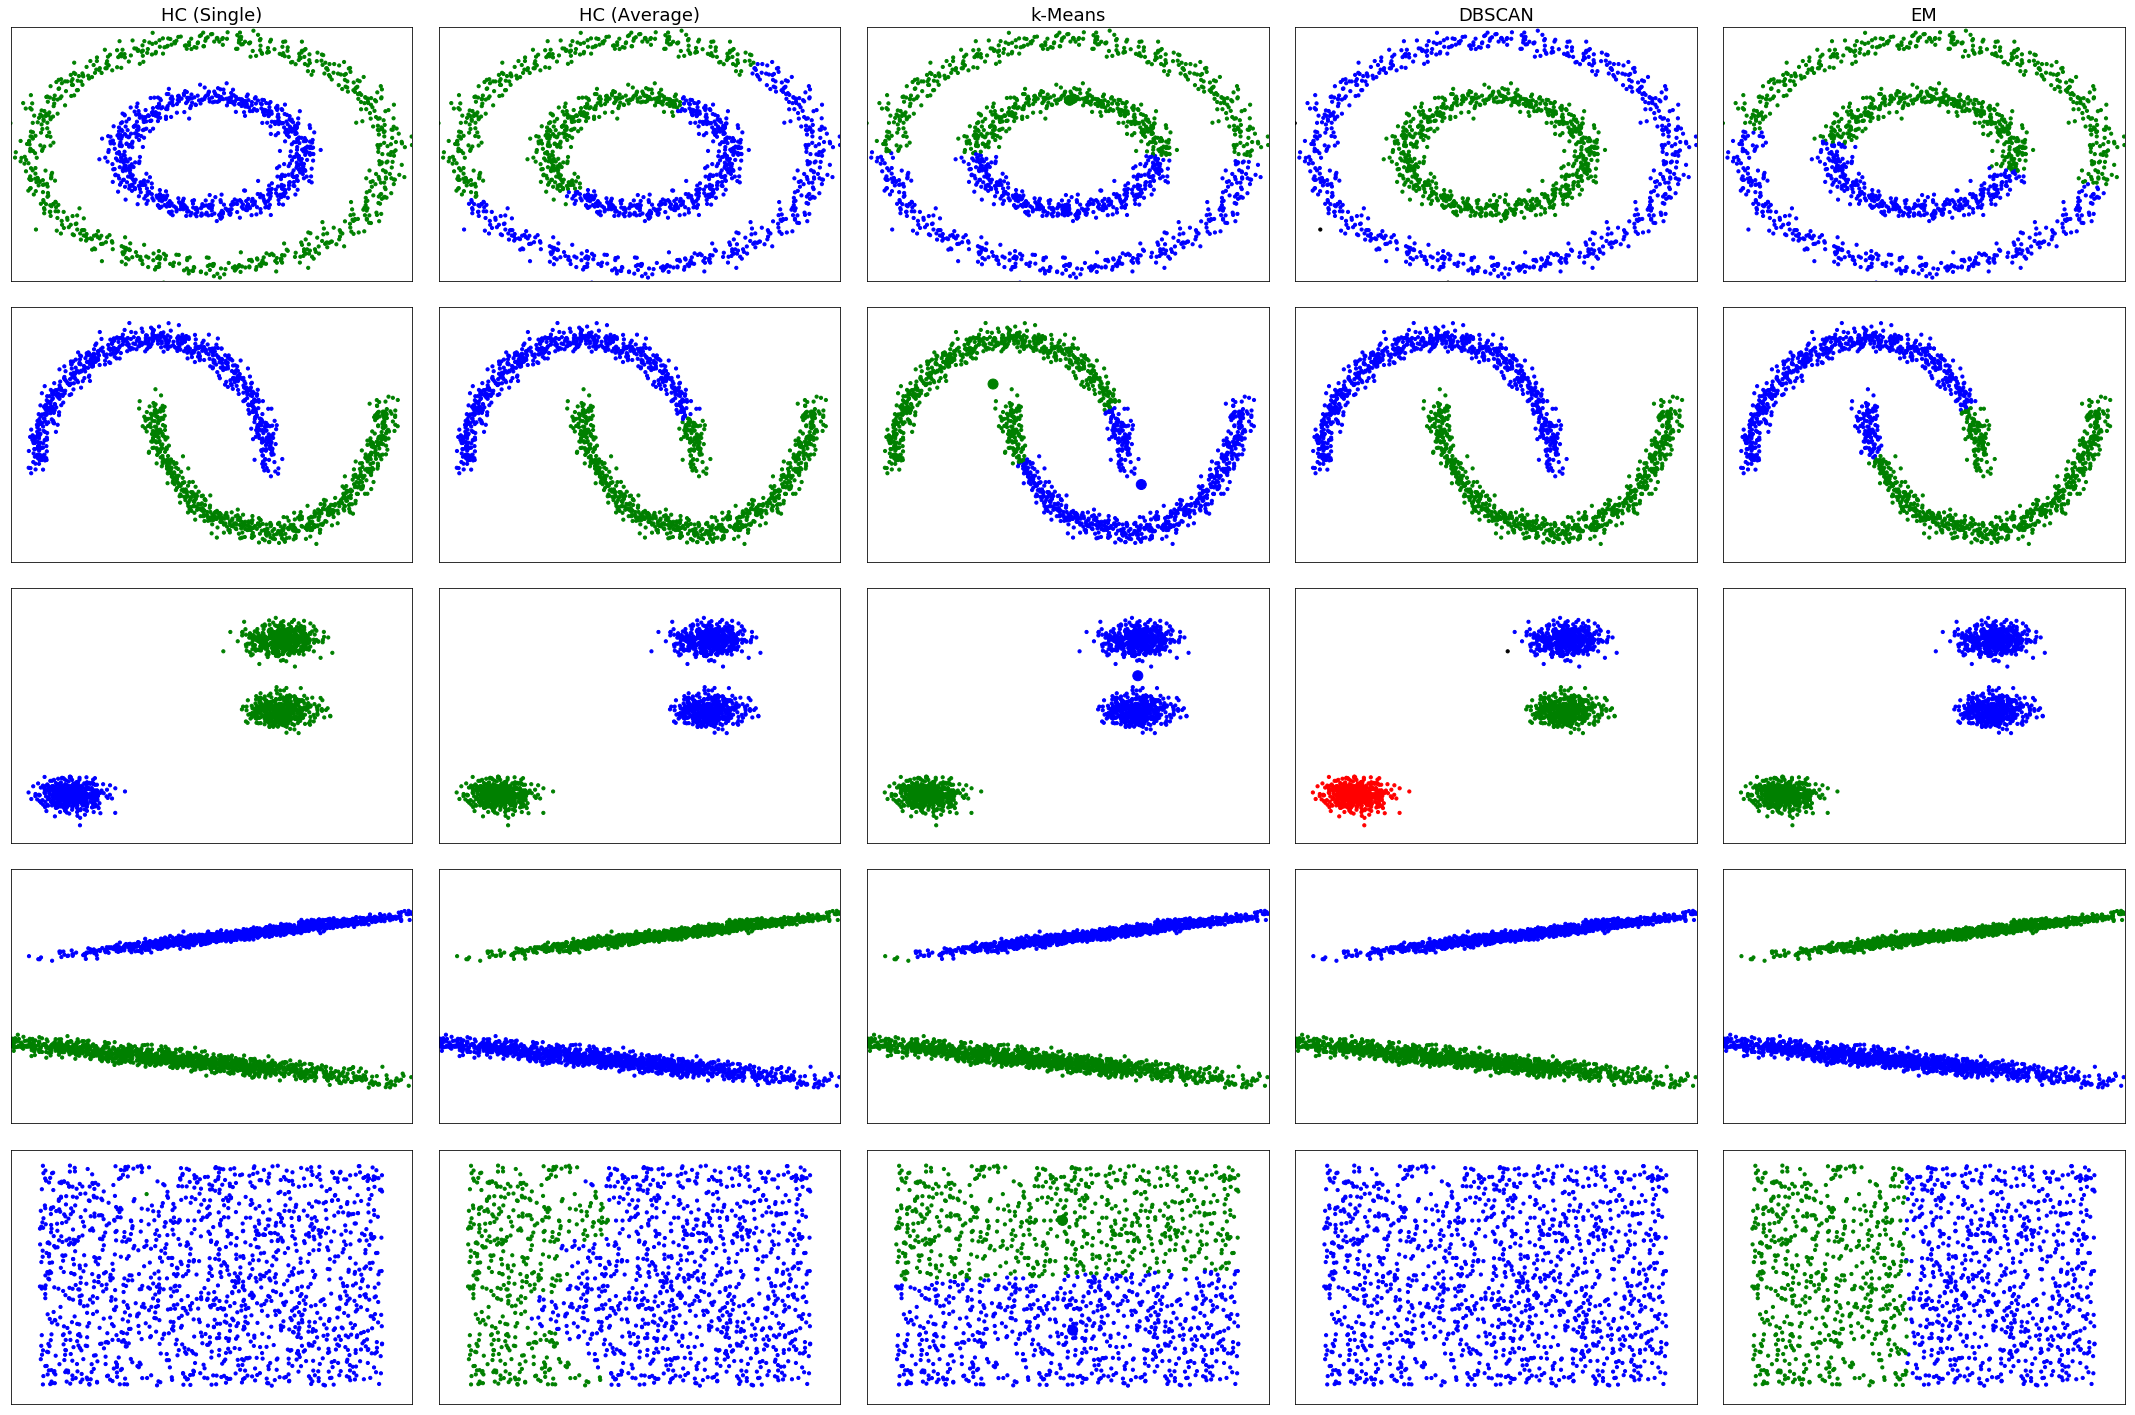

In [41]:
plt.figure(figsize=(len(clustering_names) * 5 + 5, 20))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, diagonal, no_structure]

for i_dataset, dataset in enumerate(datasets):
        
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # create clustering estimators
    
    # plain hierarchical clustering
    Z = linkage(X, 'single')
    hc = fcluster(Z, 2, criterion='maxclust')

    #
    # EXERCISE: check what happens if connectivity parameter is set used 
    #
    
    use_connectivity=False
    
    if use_connectivity:
        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)
        average_linkage = cluster.AgglomerativeClustering(
            linkage="average", affinity="cityblock", n_clusters=2,connectivity=connectivity)
    else:
        average_linkage = cluster.AgglomerativeClustering(
            linkage="average", affinity="cityblock", n_clusters=2)


    kmeans = cluster.KMeans(n_clusters=2, init='random')
    dbscan = cluster.DBSCAN(eps=.2)
    gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)

    clustering_algorithms = [hc, average_linkage, kmeans, dbscan, gmm]

    for name, algorithm in zip(clustering_names, clustering_algorithms):

        # predict cluster memberships
        if name!='HC (Single)':
            t0 = time.time()
            algorithm.fit(X)
            t1 = time.time()
        
        if name=='HC (Single)':
            y_pred = hc
            y_pred = y_pred-1
        else:
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

        ###
        ### plot
        ###
        plt.subplot(5, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.tight_layout()
plt.show();

## Exercise
- What happens if we select 3 or four clusters?
- How the results of HC (Average) change when the connectivity is added?